In [17]:
import numpy as np
import pandas as pd

cleaned_df = pd.read_excel('clean_data_for_ml_training.xlsx', index_col=None)
cleaned_df = cleaned_df.drop(['Unnamed: 0'], axis=1)
X = cleaned_df.drop(columns=['price_usd'])
y = cleaned_df['price_usd']

<h1>Bayesian optimization</h1>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

def preprocess_data(X, y):
    print("[INFO] Scaling and splitting data...")
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'pkls/scaler.pkl')
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def calculate_metrics(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MSE": mse,
        "MAPE": mape,
        "R2": r2
    }

def plot_loss(model):
    history = model.get_evals_result()
    iterations = range(len(history['learn']['RMSE']))

    plt.figure(figsize=(10, 5))
    plt.plot(iterations, history['learn']['RMSE'], label="Train RMSE")
    plt.plot(iterations, history['validation']['RMSE'], label="Validation RMSE")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def bayesian_catboost_tuning(X, y):
    X_train, X_test, y_train, y_test = preprocess_data(X, y)

    print("[INFO] Running Bayesian optimization for CatBoost...")

    base_model = CatBoostRegressor(
        loss_function='RMSE',
        early_stopping_rounds=50,
        verbose=False,
        random_seed=42
    )

    search_space = {
        'iterations': Integer(300, 1000),
        'depth': Integer(4, 10),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'l2_leaf_reg': Real(1, 10),
        'border_count': Integer(32, 254),
        'colsample_bylevel': Real(0.5, 1.0),
        'bootstrap_type': Categorical(['Bayesian', 'Bernoulli']),
        'subsample': Real(0.5, 1.0),
    }

    def custom_callback(params):
        # Remove 'subsample' if bootstrap_type is Bayesian
        if params['bootstrap_type'] == 'Bayesian':
            params.pop('subsample', None)
        return params

    class SafeCatBoostRegressor(CatBoostRegressor):
        def set_params(self, **params):
            filtered = custom_callback(params.copy())
            return super().set_params(**filtered)

    opt = BayesSearchCV(
        estimator=SafeCatBoostRegressor(
            loss_function='RMSE',
            early_stopping_rounds=50,
            verbose=False,
            random_seed=23
        ),
        search_spaces=search_space,
        n_iter=30,
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    opt.fit(X_train, y_train)

    best_params = opt.best_params_
    print(f"[INFO] Best hyperparameters: {best_params}")

    # Clean best_params for final model instantiation
    clean_params = best_params.copy()
    if clean_params['bootstrap_type'] == 'Bayesian':
        clean_params.pop('subsample', None)

    best_model = CatBoostRegressor(
        **clean_params,
        loss_function='RMSE',
        early_stopping_rounds=50,
        random_seed=42,
        verbose=False
    )

    best_model.fit(X_train, y_train, eval_set=(X_test, y_test))

    y_pred = best_model.predict(X_test)

    plot_loss(best_model)

    return calculate_metrics(y_test, y_pred), best_model, best_params


<h1>Model implementation</h1>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

def preprocess_data(X, y):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'pkls/scaler.pkl')
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def calculate_metrics(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MSE": mse,
        "MAPE": mape,
        "R2": r2
    }

def catboost_tuning(X, y):
    X_train, X_test, y_train, y_test = preprocess_data(X, y)

    param_grid = {
        'iterations': [1000],
        'depth': [10],
        'learning_rate': [0.17008818135762827],
        'l2_leaf_reg': [1],
        'border_count': [254],  
        'loss_function': ['RMSE'],  
        'early_stopping_rounds': [10],  
        'subsample': [0.8],  
        'colsample_bylevel': [1.0],  
        'bootstrap_type': ['Bernoulli'],  
        'leaf_estimation_iterations': [10],  
        'verbose': [False]  
    }
    param_combinations = list(product(*param_grid.values()))
    total_iterations = len(param_combinations)

    best_params = {}
    best_score = float('-inf')
    best_model = None

    for iteration, param_values in enumerate(param_combinations, start=1):
        param_dict = dict(zip(param_grid.keys(), param_values))

        print(f"Iteration {iteration}/{total_iterations}: {param_dict}")

        model = CatBoostRegressor(**param_dict, random_seed=42)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=False)

        score = model.score(X_test, y_test)

        if score > best_score:
            best_score = score
            best_model = model
            best_params = param_dict

    y_pred = best_model.predict(X_test)

    plot_loss(best_model)

    return calculate_metrics(y_test, y_pred), best_model, best_params

def plot_loss(model):
    history = model.get_evals_result()
    iterations = range(len(history['learn']['RMSE']))

    plt.figure(figsize=(10, 5))
    plt.plot(iterations, history['learn']['RMSE'], label="Train Loss")
    plt.plot(iterations, history['validation']['RMSE'], label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()


Iteration 1/1: {'iterations': 1000, 'depth': 10, 'learning_rate': 0.17008818135762827, 'l2_leaf_reg': 1, 'border_count': 254, 'loss_function': 'RMSE', 'early_stopping_rounds': 10, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'bootstrap_type': 'Bernoulli', 'leaf_estimation_iterations': 10, 'verbose': False}


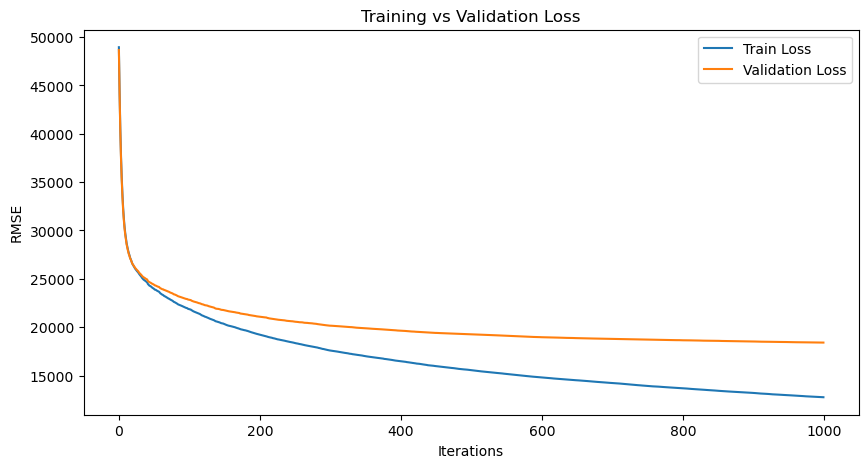

In [20]:
catboost_metrics, catboost_best_model, catboost_best_params = catboost_tuning(X, y)

Prediction: 136985.29
Confidence Interval (approx. 95%): 136985.29 to 136985.29
Standard Deviation: 0.00


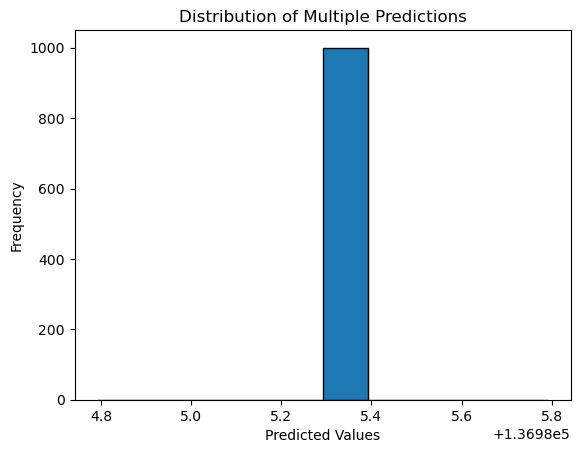

In [21]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler

def preprocess_data_single_entry(X, scaler):
    X_scaled = scaler.transform(X)
    return X_scaled

def prepare_input(incoming_data: pd.DataFrame, expected_columns: list) -> pd.DataFrame:
    categorical_cols = ['district_name', 'foundation_name', 'layout_name', 'repair_name', 'wc_name']
    incoming_encoded = pd.get_dummies(incoming_data, columns=categorical_cols)

    # Add missing columns
    for col in expected_columns:
        if col not in incoming_encoded.columns:
            incoming_encoded[col] = 0

    incoming_encoded = incoming_encoded[[col for col in expected_columns]]

    incoming_encoded = incoming_encoded[expected_columns]

    incoming_encoded = incoming_encoded.astype(int)

    return incoming_encoded

def predict_with_uncertainty(model, X_row: pd.DataFrame, n_samples=1000):
    """Generate multiple predictions with different random seeds to estimate uncertainty."""
    predictions = [model.predict(X_row)[0] for _ in range(n_samples)]
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    
    return {
        'prediction': mean_pred,
        'lower_bound': mean_pred - std_pred,
        'upper_bound': mean_pred + std_pred,
        'std_dev': std_pred,
        'all_pred': predictions
    }

# Load pre-trained model and MinMaxScaler
model = catboost_best_model
scaler = joblib.load("pkls/scaler.pkl")  # Ensure correct path

# Load expected columns from training phase
expected_columns = X.columns  # Ensure correct path

# New raw incoming data
incoming_data = pd.DataFrame([{
    "district_name": "Чиланзарский район",
    "number_of_rooms": "5",
    "floors": "1",
    "total_floors": "5",
    "total_area": "120",
    "foundation_name": "Панельный",
    "layout_name": "Смежно-раздельная",
    "wc_name": "2 санузла и более",
    "repair_name": "Евроремонт",
    "year": 2024,
    "month":11,
    "is_primary": "1"
}])


# Preprocess: One-hot encode + align features + scale
processed_input = prepare_input(incoming_data, expected_columns)
scaled_input = preprocess_data_single_entry(processed_input, scaler)

# Generate prediction with uncertainty estimation
result = predict_with_uncertainty(model, scaled_input)

# Output results
print(f"Prediction: {result['prediction']:.2f}")
print(f"Confidence Interval (approx. 95%): {result['lower_bound']:.2f} to {result['upper_bound']:.2f}")
print(f"Standard Deviation: {result['std_dev']:.2f}")

# Creating histogram
plt.hist(result['all_pred'], bins=10, edgecolor='black') 
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Distribution of Multiple Predictions')

# Show the plot
plt.show()
